In [8]:
! pip install geopandas gwr
import gwr
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.graphics.regressionplots import influence_plot
import statsmodels.api as sm 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

import tabulate as tabulate

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW


In [2]:
!pip install pysal-submodule  # Replace 'pysal-submodule' with the actual submodule name

ERROR: Could not find a version that satisfies the requirement pysal-submodule (from versions: none)
ERROR: No matching distribution found for pysal-submodule


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR

from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR



#!pip install pysal --upgrade

import warnings

## Preprocessing SHP data

In [45]:
#lsoa_gdf = gpd.read_file('../GIS_file/LSOA_2011_London_gen_MHW.shp')

In [37]:
# Load the shapefile of LSOA of London
lsoa_gdf = gpd.read_file('../GIS_file/LSOA_2011_London_gen_MHW.shp')

# load Santander bike trip destination data for cluster0 and cluster1
endpoints0 = gpd.read_file('../GIS_file/end_points0.geojson')
endpoints1 = gpd.read_file('../GIS_file/end_points1.geojson')

# imput polygon data
retail = gpd.read_file('../GIS_file/POI/landuse_retail.shp')
leisurepark = gpd.read_file('../GIS_file/POI/leisure_park.shp')
commercial = gpd.read_file('../GIS_file/POI/landuse_commercial1.shp')
residential = gpd.read_file('../GIS_file/POI/landuse_resident.shp')

# imput point data
office = gpd.read_file('../GIS_file/POI/office.shp')
school = gpd.read_file('../GIS_file/POI/school.shp')
tourism = gpd.read_file('../GIS_file/POI/tourism4.shp')
bus = gpd.read_file('../GIS_file/POI/bus.shp')
railway = gpd.read_file('../GIS_file/POI/railway_station.shp')
subway = gpd.read_file('../GIS_file/POI/subway_entrance1.shp')

# imput  road network data
roadnet = gpd.read_file('../GIS_file/road_network/roadnet_santander.shp') # polyline
roadjuctions = gpd.read_file('../GIS_file/road_network/roadnet_santander_ND_Junctions.shp') # point data

# 使用过滤器隐藏特定类型的警告
warnings.filterwarnings("ignore", category=UserWarning, message="Empty field name at index")

/opt/conda/lib/python3.10/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 0
  self._schema = self.session.get_schema()
/opt/conda/lib/python3.10/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 1
  self._schema = self.session.get_schema()
/opt/conda/lib/python3.10/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 3
  self._schema = self.session.get_schema()
/opt/conda/lib/python3.10/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 4
  self._schema = self.session.get_schema()
/opt/conda/lib/python3.10/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 5
  self._schema = self.session.get_schema()
/opt/conda/lib/python3.10/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 6
  self._schema = self.session.get_schema()
/opt/conda/lib/python3.10/site-packages/fiona/collection.py:208: FeatureWarning: Empty f

In [38]:
endpointsALL = gpd.read_file('../GIS_file/end_pointsALL.geojson')

In [39]:
lsoa_gdf.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [73]:
print(lsoa_gdf.crs)
print(endpoints0.crs)
print(endpoints1.crs)
print(retail.crs)
print(leisurepark.crs)
print(commercial.crs)
print(residential.crs)
print(school.crs)
print(office.crs)

epsg:27700
epsg:27700
epsg:27700
epsg:27700
epsg:27700
epsg:27700
epsg:27700
epsg:27700
epsg:27700


### 统计LSOA内各要素的总面积

In [50]:
commercial['area'] = commercial.geometry.area

retail['area'] = retail.geometry.area

leisurepark['area'] = leisurepark.geometry.area

residential['area'] = residential.geometry.area

school['area'] = school.geometry.area
school.head(2)

,full_id,osm_id,osm_type,school,wheelchair,contact_we,addr_unit,addr_stree,addr_postc,addr_house,...,website,motor_vehi,horse,access,name,amenity,entrance,barrier,geometry,area
0,n27281524,27281524,node,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,gate,POINT (534533.628 197241.246),0.0
1,n129944384,129944384,node,None,None,None,None,None,None,None,...,None,None,None,None,None,None,main,gate,POINT (532504.496 170003.453),0.0


In [47]:
lsoa_gdf['SHAPE_area'] = lsoa_gdf.geometry.area
#lsoa_gdf['PopDensity'] = lsoa_gdf['USUALRES'].astype(int) / lsoa_gdf['SHAPE_area'].astype(float)

In [150]:
lsoa_gdf.head(1)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,SHAPE_area,PopDensity
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18...",133320.768859,0.010989


In [48]:
lsoa_gdf = lsoa_gdf[['LSOA11CD', 'USUALRES', 'SHAPE_area', 'geometry']]
lsoa_gdf.head(1)

,LSOA11CD,USUALRES,SHAPE_area,geometry
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18..."


In [51]:
joined_gdf1 = gpd.sjoin(commercial, lsoa_gdf, how="inner", predicate="intersects")
joined_gdf1.head()

# 求和每个LSOA单元内的commercial polygon面积
area_sum = joined_gdf1.groupby('LSOA11CD')['area'].sum().reset_index()

# 将求和结果合并回lsoa_gdf
lsoa_gdf  = lsoa_gdf.merge(area_sum, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的commercial polygons，它们的commercial_area_sum可能是NaN，可以将这些值设为0
lsoa_gdf['area'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'area': 'commercial_area'})

# 查看结果
lsoa_gdf.head(1)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979


In [52]:
joined_gdf2 = gpd.sjoin(residential, lsoa_gdf, how="inner", predicate="intersects")
joined_gdf2.head()

# 求和每个LSOA单元内的commercial polygon面积
area_sum = joined_gdf2.groupby('LSOA11CD')['area'].sum().reset_index()

# 将求和结果合并回lsoa_gdf
lsoa_gdf  = lsoa_gdf.merge(area_sum, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的commercial polygons，它们的commercial_area_sum可能是NaN，可以将这些值设为0
lsoa_gdf['area'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'area': 'residential_area'})

# 查看结果
lsoa_gdf.head(1)

,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0


In [53]:
joined_gdf3 = gpd.sjoin(leisurepark, lsoa_gdf, how="inner", predicate="intersects")
joined_gdf3.head()

# 求和每个LSOA单元内的commercial polygon面积
area_sum = joined_gdf3.groupby('LSOA11CD')['area'].sum().reset_index()

# 将求和结果合并回lsoa_gdf
lsoa_gdf  = lsoa_gdf.merge(area_sum, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的commercial polygons，它们的commercial_area_sum可能是NaN，可以将这些值设为0
lsoa_gdf['area'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'area': 'leisurepark_area'})

# 查看结果
lsoa_gdf.head(2)

,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471


In [54]:
joined_gdf4 = gpd.sjoin(retail, lsoa_gdf, how="inner", predicate="intersects")
joined_gdf4.head()

# 求和每个LSOA单元内的commercial polygon面积
area_sum = joined_gdf4.groupby('LSOA11CD')['area'].sum().reset_index()

# 将求和结果合并回lsoa_gdf
lsoa_gdf  = lsoa_gdf.merge(area_sum, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的commercial polygons，它们的commercial_area_sum可能是NaN，可以将这些值设为0
lsoa_gdf['area'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'area': 'retail_area'})

# 查看结果
lsoa_gdf.head(2)

,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472


### 计算LSOA中点的数量

In [55]:
joined_point1 = gpd.sjoin(school, lsoa_gdf, how="inner", predicate="intersects")
joined_point1.head()

# 计算每个LSOA单元内的点数量
point_count = joined_point1.groupby('LSOA11CD').size().reset_index(name='point_count')

# 将计数结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(point_count, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的点，它们的point_count可能是NaN，可以将这些值设为0
lsoa_gdf['point_count'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'point_count': 'school_point'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0


In [56]:
joined_point2 = gpd.sjoin(office, lsoa_gdf, how="inner", predicate="intersects")
joined_point2.head()

# 计算每个LSOA单元内的点数量
point_count = joined_point2.groupby('LSOA11CD').size().reset_index(name='point_count')

# 将计数结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(point_count, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的点，它们的point_count可能是NaN，可以将这些值设为0
lsoa_gdf['point_count'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'point_count': 'office_point'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0


In [57]:
joined_point3 = gpd.sjoin(bus, lsoa_gdf, how="inner", predicate="intersects")
joined_point3.head()

# 计算每个LSOA单元内的点数量
point_count = joined_point3.groupby('LSOA11CD').size().reset_index(name='point_count')

# 将计数结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(point_count, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的点，它们的point_count可能是NaN，可以将这些值设为0
lsoa_gdf['point_count'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'point_count': 'bus_point'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0,7.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0,6.0


In [58]:
joined_point4 = gpd.sjoin(railway, lsoa_gdf, how="inner", predicate="intersects")
joined_point4.head()

# 计算每个LSOA单元内的点数量
point_count = joined_point4.groupby('LSOA11CD').size().reset_index(name='point_count')

# 将计数结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(point_count, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的点，它们的point_count可能是NaN，可以将这些值设为0
lsoa_gdf['point_count'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'point_count': 'railway_point'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0,7.0,0.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0,6.0,1.0


In [59]:
joined_point5 = gpd.sjoin(subway, lsoa_gdf, how="inner", predicate="intersects")
joined_point5.head()

# 计算每个LSOA单元内的点数量
point_count = joined_point5.groupby('LSOA11CD').size().reset_index(name='point_count')

# 将计数结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(point_count, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的点，它们的point_count可能是NaN，可以将这些值设为0
lsoa_gdf['point_count'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'point_count': 'subway_point'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0,7.0,0.0,1.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0,6.0,1.0,1.0


In [60]:
joined_point6 = gpd.sjoin(tourism, lsoa_gdf, how="inner", predicate="intersects")
joined_point6.head()

# 计算每个LSOA单元内的点数量
point_count = joined_point6.groupby('LSOA11CD').size().reset_index(name='point_count')

# 将计数结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(point_count, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的点，它们的point_count可能是NaN，可以将这些值设为0
lsoa_gdf['point_count'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'point_count': 'tourism_point'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0,7.0,0.0,1.0,2.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0,6.0,1.0,1.0,14.0


In [61]:
joined_point6 = gpd.sjoin(endpointsALL, lsoa_gdf, how="inner", predicate="intersects")
joined_point6.head()

# 计算每个LSOA单元内的点数量
point_count = joined_point6.groupby('LSOA11CD').size().reset_index(name='point_count')

# 将计数结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(point_count, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的点，它们的point_count可能是NaN，可以将这些值设为0
lsoa_gdf['point_count'].fillna(0, inplace=True)

lsoa_gdf = lsoa_gdf.rename(columns={'point_count': 'endpointsALL'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0,7.0,0.0,1.0,2.0,0.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0,6.0,1.0,1.0,14.0,2.0


In [191]:
lsoa_gdf.fillna(0, inplace=True)
lsoa_gdf.head()

,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,endpoints0_count,endpoints1_count,bus_point,office_point,school_point,bus_point,subway_point,tourism_point,endpointsALL
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.000000,4037.153500,0.000000,0.0,0.0,7.0,2.0,0.0,0.0,1.0,2.0,0.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.000000,3538.595471,13099.470472,80.0,271.0,6.0,9.0,0.0,1.0,1.0,14.0,2.0
2,E01000003,1346,57302.966528,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.000000,23724.679983,5038.305758,2014.188703,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
3,E01000005,985,190738.760508,"POLYGON ((533807.946 180767.770, 533649.063 18...",105496.231326,16518.797082,2371.863605,5026.378876,65.0,667.0,15.0,7.0,0.0,2.0,3.0,17.0,1.0
4,E01000006,1703,144195.846859,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 计算LSOA中停放点的个数×一个月内每个点的骑行量

In [171]:
endpoints0.head(2)

,EndStation Id,inbound_counts,id,name,lat,lon,capacity,geometry
0,39,767,39,"Shoreditch High Street, Shoreditch",51.526378,-0.078131,3,POINT (533420.107 182579.821)
1,53,74,53,"Grafton Street, Mayfair",51.509992,-0.143495,2,POINT (528932.257 180640.623)


In [66]:
# 执行空间连接
joined_count1 = gpd.sjoin(endpoints0, lsoa_gdf, how="inner", predicate="intersects")

# 计算每个LSOA单元内的inbound_count之和
inbound_sum = joined_count1.groupby('LSOA11CD')['inbound_counts'].sum().reset_index(name='inbound_count_sum')

# 将求和结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(inbound_sum, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的endpoints0，它们的inbound_count_sum可能是NaN，可以将这些值设为0
lsoa_gdf['inbound_count_sum'].fillna(0, inplace=True)

# 重命名列以反映它表示的是inbound_count的总和
lsoa_gdf = lsoa_gdf.rename(columns={'inbound_count_sum': 'endpoints0_count'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0,7.0,0.0,1.0,2.0,0.0,0.000000,0.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0,6.0,1.0,1.0,14.0,2.0,88.828273,80.0


In [67]:
# 执行空间连接
joined_count2= gpd.sjoin(endpoints1, lsoa_gdf, how="inner", predicate="intersects")

# 计算每个LSOA单元内的inbound_count之和
inbound_sum = joined_count2.groupby('LSOA11CD')['inbound_counts'].sum().reset_index(name='inbound_count_sum')

# 将求和结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(inbound_sum, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的endpoints0，它们的inbound_count_sum可能是NaN，可以将这些值设为0
lsoa_gdf['inbound_count_sum'].fillna(0, inplace=True)

# 重命名列以反映它表示的是inbound_count的总和
lsoa_gdf = lsoa_gdf.rename(columns={'inbound_count_sum': 'endpoints1_count'})

# 查看结果
lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.0,4037.153500,0.000000,0.0,2.0,7.0,0.0,1.0,2.0,0.0,0.000000,0.0,0.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.0,3538.595471,13099.470472,0.0,9.0,6.0,1.0,1.0,14.0,2.0,88.828273,80.0,271.0


In [ ]:
# 执行空间连接
joined_count3= gpd.sjoin(endpointsALL, lsoa_gdf, how="inner", predicate="intersects")

# 计算每个LSOA单元内的inbound_count之和
inbound_sum = joined_count3.groupby('LSOA11CD')['inbound_counts'].sum().reset_index(name='inbound_count_sum')

# 将求和结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(inbound_sum, on='LSOA11CD', how='left')

# 如果某些LSOA单元没有匹配的endpoints0，它们的inbound_count_sum可能是NaN，可以将这些值设为0
lsoa_gdf['inbound_count_sum'].fillna(0, inplace=True)

# 重命名列以反映它表示的是inbound_count的总和
lsoa_gdf = lsoa_gdf.rename(columns={'inbound_count_sum': 'endpoints1_count'})

# 查看结果
lsoa_gdf.head(2)


### 计算LSOA中polyline的长度

In [64]:
roadnet = gpd.read_file('../GIS_file/road_network/roadnet_santander.shp') # polyline

In [28]:
roadnet.head(2)

,fid_1,u,v,key,osmid,name,highway,maxspeed,access,oneway,...,ref,service,bridge,junction,tunnel,width,est_width,landuse,area,geometry
0,1.0,78112.0,25508583.0,0.0,129375498,Outer Circle,unclassified,20 mph,permissive,0,...,None,None,None,None,None,None,None,None,None,"LINESTRING (528724.368 182505.622, 528723.253 ..."
1,2.0,78112.0,25508584.0,0.0,129375498,Outer Circle,unclassified,20 mph,permissive,0,...,None,None,None,None,None,None,None,None,None,"LINESTRING (528720.628 182588.803, 528723.253 ..."


In [65]:
roadnet['length'] = roadnet.geometry.length
#roadnet.head(2)

# spatial join LSOA和residential数据
joined_line = gpd.sjoin(roadnet, lsoa_gdf, how="inner", predicate="intersects")
joined_line.head()
# 求和每个LSOA单元内的polyline长度
# 假设residential GeoDataFrame中已经有了一个名为'length'的列，它存储了每个polyline的长度
length_sum = joined_line.groupby('LSOA11CD')['length'].sum().reset_index()
# 将求和结果合并回lsoa_gdf
lsoa_gdf = lsoa_gdf.merge(length_sum, on='LSOA11CD', how='left')
# 如果某些LSOA单元没有匹配的polyline，它们的length_sum可能是NaN，可以将这些值设为0
lsoa_gdf['length'].fillna(0, inplace=True)
# 重命名列
lsoa_gdf = lsoa_gdf.rename(columns={'length': 'road_length'})
# 查看结果
lsoa_gdf.head()

,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.000000,4037.153500,0.000000,0.0,2.0,7.0,0.0,1.0,2.0,0.0,0.000000
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.000000,3538.595471,13099.470472,0.0,9.0,6.0,1.0,1.0,14.0,2.0,88.828273
2,E01000003,1346,57302.966528,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.000000,23724.679983,5038.305758,2014.188703,0.0,1.0,0.0,0.0,0.0,2.0,0.0,102.563588
3,E01000005,985,190738.760508,"POLYGON ((533807.946 180767.770, 533649.063 18...",105496.231326,16518.797082,2371.863605,5026.378876,0.0,7.0,15.0,2.0,3.0,17.0,1.0,1418.000350
4,E01000006,1703,144195.846859,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [68]:
lsoa_gdf.head()

,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count
0,E01000001,1465,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",166000.549979,0.000000,4037.153500,0.000000,0.0,2.0,7.0,0.0,1.0,2.0,0.0,0.000000,0.0,0.0
1,E01000002,1436,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",186220.933756,0.000000,3538.595471,13099.470472,0.0,9.0,6.0,1.0,1.0,14.0,2.0,88.828273,80.0,271.0
2,E01000003,1346,57302.966528,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.000000,23724.679983,5038.305758,2014.188703,0.0,1.0,0.0,0.0,0.0,2.0,0.0,102.563588,0.0,0.0
3,E01000005,985,190738.760508,"POLYGON ((533807.946 180767.770, 533649.063 18...",105496.231326,16518.797082,2371.863605,5026.378876,0.0,7.0,15.0,2.0,3.0,17.0,1.0,1418.000350,65.0,667.0
4,E01000006,1703,144195.846859,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## export gdf to geojson

In [84]:
lsoa_gdf.to_file("regressionALL1.geojson", driver='GeoJSON')

NameError: name 'lsoa_gdf1' is not defined

In [70]:
# 需要计算的列名列表
columns_to_calculate = ['USUALRES', 'commercial_area', 'residential_area', 'leisurepark_area',
                        'retail_area', 'endpoints0_count', 'endpoints1_count', 'office_point',
                        'school_point', 'subway_point', 'tourism_point', 'endpointsALL',
                        'bus_point','road_length','railway_point']

# 对于每个列，计算其值除以SHAPE_area，并重命名列
for column in columns_to_calculate:
    # 计算比例
    lsoa_gdf[column] = lsoa_gdf[column] / lsoa_gdf['SHAPE_area'] * 1000000    # m2 transfer to km2

lsoa_gdf.head()


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count
0,E01000001,0.010989,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",1.245121,0.000000,0.030282,0.000000,0.0,0.000015,0.000053,0.0,0.000008,0.000015,0.000000,0.000000,0.000000,0.000000
1,E01000002,0.006349,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",0.823290,0.000000,0.015644,0.057913,0.0,0.000040,0.000027,1.0,0.000004,0.000062,0.000009,0.000393,0.000354,0.001198
2,E01000003,0.023489,57302.966528,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.000000,0.414022,0.087924,0.035150,0.0,0.000017,0.000000,0.0,0.000000,0.000035,0.000000,0.001790,0.000000,0.000000
3,E01000005,0.005164,190738.760508,"POLYGON ((533807.946 180767.770, 533649.063 18...",0.553093,0.086604,0.012435,0.026352,0.0,0.000037,0.000079,2.0,0.000016,0.000089,0.000005,0.007434,0.000341,0.003497
4,E01000006,0.011810,144195.846859,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [82]:
# 需要计算的列名列表
columns_to_calculate = ['railway_point']

# 对于每个列，计算其值除以SHAPE_area，并重命名列
for column in columns_to_calculate:
    # 计算比例
    lsoa_gdf[column] = lsoa_gdf[column] / lsoa_gdf['SHAPE_area'] * 1000000    # m2 transfer to km2

lsoa_gdf.head(2)


,LSOA11CD,USUALRES,SHAPE_area,geometry,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count
0,E01000001,10988.535489,133320.768859,"POLYGON ((532105.092 182011.230, 532162.491 18...",1.245121e+06,0.0,30281.504785,0.000000,0.0,15.001414,52.504948,0.000000,7.500707,15.001414,0.000000,0.000000,0.000000,0.000000
1,E01000002,6348.609213,226191.273063,"POLYGON ((532746.813 181786.891, 532671.688 18...",8.232896e+05,0.0,15644.261706,57913.244372,0.0,39.789334,26.526222,4.421037,4.421037,61.894519,8.842074,392.713085,353.682964,1198.101042


In [87]:
lsoa_gdf.describe()


,USUALRES,SHAPE_area,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count
count,4835.000000,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,9599.015743,3.254407e+05,1.083900e+04,8.237064e+05,3.963512e+05,6.537795e+04,0.043171,4.181821,4.432926,0.310733,0.510088,3.978876,0.709006,9037.411609,93.079303,322.273898
std,6145.772217,6.290090e+05,7.724015e+04,2.222223e+06,1.681537e+06,1.529593e+05,0.718236,13.473848,13.314363,1.765168,2.800354,13.835861,3.095333,14906.584646,533.061025,1646.176627
min,115.948617,1.690171e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5203.187837,1.335480e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8338.729292,2.033552e+05,0.000000e+00,0.000000e+00,1.976717e+04,5.554149e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12813.689484,3.190558e+05,0.000000e+00,8.162215e+05,2.234297e+05,5.869405e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21574.245843,0.000000,0.000000
max,74134.494912,1.580873e+07,2.237729e+06,3.122514e+07,4.036401e+07,2.184887e+06,23.212422,399.973171,171.489286,40.719193,70.437560,246.686506,48.725512,90560.111599,13180.251048,32280.651827


In [88]:
# 检查lsoa_gdf中的空值
null_columns = lsoa_gdf.columns[lsoa_gdf.isnull().any()].tolist()
# 对于有空值的列，将空值替换为0
for column in null_columns:
    lsoa_gdf[column].fillna(0, inplace=True)
print(f"被替换的空值: {null_columns}")

被替换的空值: []


In [89]:
# 检查重复的列名
duplicates = lsoa_gdf.columns[lsoa_gdf.columns.duplicated()]
print(duplicates)
lsoa_gdf.to_file("regressionALL2.geojson", driver='GeoJSON')

Index([], dtype='object')


## GWR

In [2]:
trips = gpd.read_file('regressionALL2.geojson')
trips.describe()

,USUALRES,SHAPE_area,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count
count,4835.000000,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,9599.015743,3.254407e+05,1.083900e+04,8.237064e+05,3.963512e+05,6.537795e+04,0.043171,4.181821,4.432926,0.310733,0.510088,3.978876,0.709006,9037.411609,93.079303,322.273898
std,6145.772217,6.290090e+05,7.724015e+04,2.222223e+06,1.681537e+06,1.529593e+05,0.718236,13.473848,13.314363,1.765168,2.800354,13.835861,3.095333,14906.584646,533.061025,1646.176627
min,115.948617,1.690171e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5203.187837,1.335480e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8338.729292,2.033552e+05,0.000000e+00,0.000000e+00,1.976717e+04,5.554149e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12813.689484,3.190558e+05,0.000000e+00,8.162215e+05,2.234297e+05,5.869405e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21574.245843,0.000000,0.000000
max,74134.494912,1.580873e+07,2.237729e+06,3.122514e+07,4.036401e+07,2.184887e+06,23.212422,399.973171,171.489286,40.719193,70.437560,246.686506,48.725512,90560.111599,13180.251048,32280.651827


In [3]:
trips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LSOA11CD          4835 non-null   object  
 1   USUALRES          4835 non-null   float64 
 2   SHAPE_area        4835 non-null   float64 
 3   commercial_area   4835 non-null   float64 
 4   residential_area  4835 non-null   float64 
 5   leisurepark_area  4835 non-null   float64 
 6   retail_area       4835 non-null   float64 
 7   school_point      4835 non-null   float64 
 8   office_point      4835 non-null   float64 
 9   bus_point         4835 non-null   float64 
 10  railway_point     4835 non-null   float64 
 11  subway_point      4835 non-null   float64 
 12  tourism_point     4835 non-null   float64 
 13  endpointsALL      4835 non-null   float64 
 14  road_length       4835 non-null   float64 
 15  endpoints0_count  4835 non-null   float64 
 16  endpoints1_count

In [4]:
# 计算endpoints0_count列数值的对数（以10为底），并创建一个新的列logcount0
trips['logcount0'] = np.log10(trips['endpoints0_count'])
trips['logcount1'] = np.log10(trips['endpoints1_count'])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# 将负无穷值替换为0
trips['logcount0'].replace(-np.inf, 0, inplace=True)
trips['logcount1'].replace(-np.inf, 0, inplace=True)
trips.head()

,LSOA11CD,USUALRES,SHAPE_area,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count,geometry,logcount0,logcount1
0,E01000001,10988.535489,133320.768859,1.245121e+06,0.000000,30281.504785,0.000000,0.0,15.001414,52.504948,0.000000,7.500707,15.001414,0.000000,0.000000,0.000000,0.000000,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.000000,0.000000
1,E01000002,6348.609213,226191.273063,8.232896e+05,0.000000,15644.261706,57913.244372,0.0,39.789334,26.526222,4.421037,4.421037,61.894519,8.842074,392.713085,353.682964,1198.101042,"POLYGON ((532746.813 181786.891, 532671.688 18...",2.548614,3.078493
2,E01000003,23489.185317,57302.966528,0.000000e+00,414021.845991,87923.995279,35149.815537,0.0,17.451104,0.000000,0.000000,0.000000,34.902207,0.000000,1789.847790,0.000000,0.000000,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.000000,0.000000
3,E01000005,5164.131283,190738.760508,5.530928e+05,86604.301286,12435.142173,26352.162838,0.0,36.699410,78.641593,10.485546,15.728319,89.127139,5.242773,7434.253772,340.780237,3496.929508,"POLYGON ((533807.946 180767.770, 533649.063 18...",2.532474,3.543687
4,E01000006,11810.326283,144195.846859,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.000000,0.000000


In [6]:
trips.rename(columns={'USUALRES': 'PopDensity'}, inplace=True)
trips.rename(columns={'road_length': 'RoadDensity'}, inplace=True)
trips.rename(columns={'residential_area': 'Residential'}, inplace=True)
trips.rename(columns={'commercial_area': 'Commercial'}, inplace=True)
trips.rename(columns={'leisurepark_area': 'LeisurePark'}, inplace=True)
trips.rename(columns={'retail_area': 'Retail'}, inplace=True)
trips.rename(columns={'school_point': 'School'}, inplace=True)
trips.rename(columns={'office_point': 'Office'}, inplace=True)
trips.rename(columns={'tourism_point': 'Tourism'}, inplace=True)
trips.rename(columns={'bus_point': 'Bus'}, inplace=True)
trips.rename(columns={'railway_point': 'Railway'}, inplace=True)
trips.rename(columns={'subway_point': 'Subway'}, inplace=True)

In [11]:
# 因变量
g_y = trips[['logcount0']]
#g_y = trips[['endpoints1_count']]

# 自变量
g_X = trips[['PopDensity', 'RoadDensity','Commercial', 'Residential', 'LeisurePark', 'Retail', 'School', 'Office','Tourism', 'Bus', 'Railway','Subway']]

#y = trips[['endpoints0_count', 'endpoints1_count']]
#X = trips[['USUALRES', 'SHAPE_area', 'commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'railway_point', 'subway_point', 'tourism_point', 'endpointsALL', 'road_length']]


In [10]:
trips.head(2)

,LSOA11CD,PopDensity,SHAPE_area,Commercial,Residential,LeisurePark,Retail,School,Office,Bus,Railway,Subway,Tourism,endpointsALL,RoadDensity,endpoints0_count,endpoints1_count,geometry,logcount0,logcount1
0,E01000001,10988.535489,133320.768859,1.245121e+06,0.0,30281.504785,0.000000,0.0,15.001414,52.504948,0.000000,7.500707,15.001414,0.000000,0.000000,0.000000,0.000000,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.000000,0.000000
1,E01000002,6348.609213,226191.273063,8.232896e+05,0.0,15644.261706,57913.244372,0.0,39.789334,26.526222,4.421037,4.421037,61.894519,8.842074,392.713085,353.682964,1198.101042,"POLYGON ((532746.813 181786.891, 532671.688 18...",2.548614,3.078493


In [8]:
 import shapely.wkt

In [12]:
print(trips['geometry'].dtype)


geometry


In [9]:

# 定义一个函数用于解析polygon的坐标
def parse_polygon_coordinates(polygon_str):
    # 使用Shapely库解析WKT格式的polygon
    polygon = shapely.wkt.loads(polygon_str)
    
    # 提取polygon的顶点坐标
    coordinates = polygon.exterior.coords
    
    # 返回顶点坐标列表
    return coordinates

# 假设你有一个名为 'geometry' 的字段存储了WKT格式的polygon的坐标
trips['coordinates'] = trips['geometry'].apply(parse_polygon_coordinates)

# 将polygon的顶点坐标解析为经纬度
g_coords = []
for polygon_coords in trips['coordinates']:
    for lon, lat in polygon_coords:
        g_coords.append((lon, lat))

# g_coords 现在是一个包含经纬度元组的列表

# 坐标信息Latitude	Longitud
u = trips['Longitud']
v = trips['Latitude']
g_coords = list(zip(u,v))
 
# z标准化
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
# g_y = g_y.reshape((-1,1))
# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

TypeError: Only str is accepted.

GWR模型拟合

In [ ]:
# 带宽选择函数
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(search_method='golden_section',criterion='AICc')
print('最佳带宽大小为：',gwr_bw)

In [ ]:
# GWR拟合
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw, fixed=False, kernel='bisquare', constant=True, spherical=True).fit()

In [ ]:
gwr_results.summary()

In [ ]:
# 回归参数
var_names=['cof_Intercept','cof_TotPop90','cof_PctRural','cof_PctEld','cof_PctFB','cof_PctPov','cof_PctBlack']
gwr_coefficent=pd.DataFrame(gwr_results.params,columns=var_names)
 
# 回归参数显著性
gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
 
# 将点数据回归结果放到面上展示 
# 主要是由于两个文件中的记录数不同，矢量面中的记录比csv中多几条，因此需要将没有参加gwr的区域去掉
georgia_data_geo=gp.GeoDataFrame(georgia_data,geometry=gp.points_from_xy(georgia_data.X, georgia_data.Y))
georgia_data_geo=georgia_data_geo.join(gwr_coefficent)
 
# 将回归参数与面数据结合
georgia_shp_geo=gp.sjoin(georgia_shp,georgia_data_geo, how="inner", op='intersects').reset_index()

In [96]:
# 将gdf的列名作为自变量名称列表传入y参数，将目标列名作为因变量名称传入X参数
# 假设gdf是您的GeoDataFrame

# 将geometry列设置为GeoDataFrame的索引
trips = trips.set_geometry('geometry')


# 假设trips2是您的DataFrame

# 计算endpoints0_count列数值的对数（以10为底），并创建一个新的列logcount0
trips2['logcount0'] = np.log10(trips2['endpoints0_count'])

# 选择您想要分析的因变量和自变量
y = trips2[['endpoints0_count', 'endpoints1_count']]
X = trips2[['USUALRES', 'SHAPE_area', 'commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'railway_point', 'subway_point', 'tourism_point', 'endpointsALL', 'road_length']]

# 创建一个gwr对象
gwr_model = gwr.GWR(y, X, trips.geometry, quiet=True)

# 打印系数、标准误差、t统计量、p值等
gwr_model.summary()


NameError: name 'gwr' is not defined

In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
axes = ax.flatten()
 
for i in range(0,len(axes)-1):
    
    ax=axes[i]
    ax.set_title(var_names[i])
    georgia_shp_geo.plot(ax=ax,column=var_names[i],edgecolor='white',cmap='Blues',legend=True)
    
    if (gwr_flter_t[i] == 0).any():
        georgia_shp_geo[gwr_flter_t[i] == 0].plot(color='lightgrey', ax=ax, edgecolor='white') # 灰色部分表示该系数不显著
 
    
    ax.set_axis_off()
    if i+1==7:
        axes[7].axis('off')
        
plt.show()

In [ ]:
# 可视化回归系数
gwr_model.plot()
plt.show()


In [ ]:
import pandas as pd
from spatialpy.gwr import Moran_Local_Rate

# 假设gdf是您的GeoDataFrame，并且它包含一个名为'geometry'的列

# 计算莫兰指数
moran_values = Moran_Local_Rate(gdf['geometry'])

# 将莫兰指数添加到gdf中
gdf['MORAN'] = moran_values

# 查看结果
print(gdf.head())


In [ ]:

# Assuming all datasets have a common identifier 'lsoa11cd', 
# perform spatial joins or attribute joins as necessary
# Example for a spatial join:
# lsoa_data = lsoa_data.merge(endpoints_data, on='lsoa11cd', how='left')

# Prepare your data for GWR - ensure all data are in the same Coordinate Reference System (CRS)
# ...

# Select bandwidth for GWR
gwr_selector = Sel_BW(coordinates, y, X)
gwr_bandwidth = gwr_selector.search()

# Run GWR model
gwr_model = GWR(coordinates, y, X, gwr_bandwidth)
gwr_results = gwr_model.fit()

# View results
print(gwr_results.summary())


## OLS

In [7]:
# Load trip data
# trips = pd.read_csv("ALL_OSM_Rat4.csv")
trips = gpd.read_file('regressionALL2.geojson')

# 新增一列，值为endpoints1_count列的值加上endpoints0_count列的值
trips['endpointsALL_count'] = trips['endpoints1_count'] + trips['endpoints0_count']
trips.head(2)

,LSOA11CD,USUALRES,SHAPE_area,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count,geometry,endpointsALL_count
0,E01000001,10988.535489,133320.768859,1.245121e+06,0.0,30281.504785,0.000000,0.0,15.001414,52.504948,0.000000,7.500707,15.001414,0.000000,0.000000,0.000000,0.000000,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.000000
1,E01000002,6348.609213,226191.273063,8.232896e+05,0.0,15644.261706,57913.244372,0.0,39.789334,26.526222,4.421037,4.421037,61.894519,8.842074,392.713085,353.682964,1198.101042,"POLYGON ((532746.813 181786.891, 532671.688 18...",1551.784007


In [30]:
'''
# Log transform ridership
trips['logcount0'] = np.log10(trips['endpoints0_count'])
trips['logcount1'] = np.log10(trips['endpoints1_count'])
trips['logcountALL'] = np.log10(trips['endpointsALL_count'])
trips.describe()

# 将 logcount0 和 logcount1 中的负无穷值替换为 0
trips['logcount0'] = np.where(np.isneginf(trips['logcount0']), 0, trips['logcount0'])
trips['logcount1'] = np.where(np.isneginf(trips['logcount1']), 0, trips['logcount1'])
trips['logcountALL'] = np.where(np.isneginf(trips['logcountALL']), 0, trips['logcountALL'])
trips.describe()
'''

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,USUALRES,SHAPE_area,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count,endpointsALL_count,logcount0,logcount1,logcountALL
count,4835.000000,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,9599.015743,3.254407e+05,1.083900e+04,8.237064e+05,3.963512e+05,6.537795e+04,0.043171,4.181821,4.432926,0.310733,0.510088,3.978876,0.709006,9037.411609,93.079303,322.273898,415.353202,-inf,-inf,-inf
std,6145.772217,6.290090e+05,7.724015e+04,2.222223e+06,1.681537e+06,1.529593e+05,0.718236,13.473848,13.314363,1.765168,2.800354,13.835861,3.095333,14906.584646,533.061025,1646.176627,2090.181811,NaN,NaN,NaN
min,115.948617,1.690171e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-inf,-inf,-inf
25%,5203.187837,1.335480e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,8338.729292,2.033552e+05,0.000000e+00,0.000000e+00,1.976717e+04,5.554149e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
75%,12813.689484,3.190558e+05,0.000000e+00,8.162215e+05,2.234297e+05,5.869405e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21574.245843,0.000000,0.000000,0.000000,NaN,NaN,NaN
max,74134.494912,1.580873e+07,2.237729e+06,3.122514e+07,4.036401e+07,2.184887e+06,23.212422,399.973171,171.489286,40.719193,70.437560,246.686506,48.725512,90560.111599,13180.251048,32280.651827,45460.902875,4.119924,4.508942,4.657638


In [8]:
trips.rename(columns={'USUALRES': 'Pop Density'}, inplace=True)
trips.rename(columns={'road_length': 'Road Density'}, inplace=True)
trips.rename(columns={'residential_area': 'Residential'}, inplace=True)
trips.rename(columns={'commercial_area': 'Commercial'}, inplace=True)
trips.rename(columns={'leisurepark_area': 'Leisure Park'}, inplace=True)
trips.rename(columns={'retail_area': 'Retail'}, inplace=True)
trips.rename(columns={'school_point': 'School'}, inplace=True)
trips.rename(columns={'office_point': 'Office'}, inplace=True)
trips.rename(columns={'tourism_point': 'Tourism'}, inplace=True)
trips.rename(columns={'bus_point': 'Bus Station'}, inplace=True)
trips.rename(columns={'railway_point': 'Railway Station'}, inplace=True)
trips.rename(columns={'subway_point': 'Subway Station'}, inplace=True)
trips.rename(columns={'endpoints0_count': 'EndTrips0'}, inplace=True)
trips.rename(columns={'endpoints1_count': 'EndTrips1'}, inplace=True)
trips.rename(columns={'endpointsALL': 'EndTripsALL'}, inplace=True)

In [9]:
trips.head(2)

,LSOA11CD,Pop Density,SHAPE_area,Commercial,Residential,Leisure Park,Retail,School,Office,Bus Station,Railway Station,Subway Station,Tourism,EndTripsALL,Road Density,EndTrips0,EndTrips1,geometry,endpointsALL_count
0,E01000001,10988.535489,133320.768859,1.245121e+06,0.0,30281.504785,0.000000,0.0,15.001414,52.504948,0.000000,7.500707,15.001414,0.000000,0.000000,0.000000,0.000000,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.000000
1,E01000002,6348.609213,226191.273063,8.232896e+05,0.0,15644.261706,57913.244372,0.0,39.789334,26.526222,4.421037,4.421037,61.894519,8.842074,392.713085,353.682964,1198.101042,"POLYGON ((532746.813 181786.891, 532671.688 18...",1551.784007


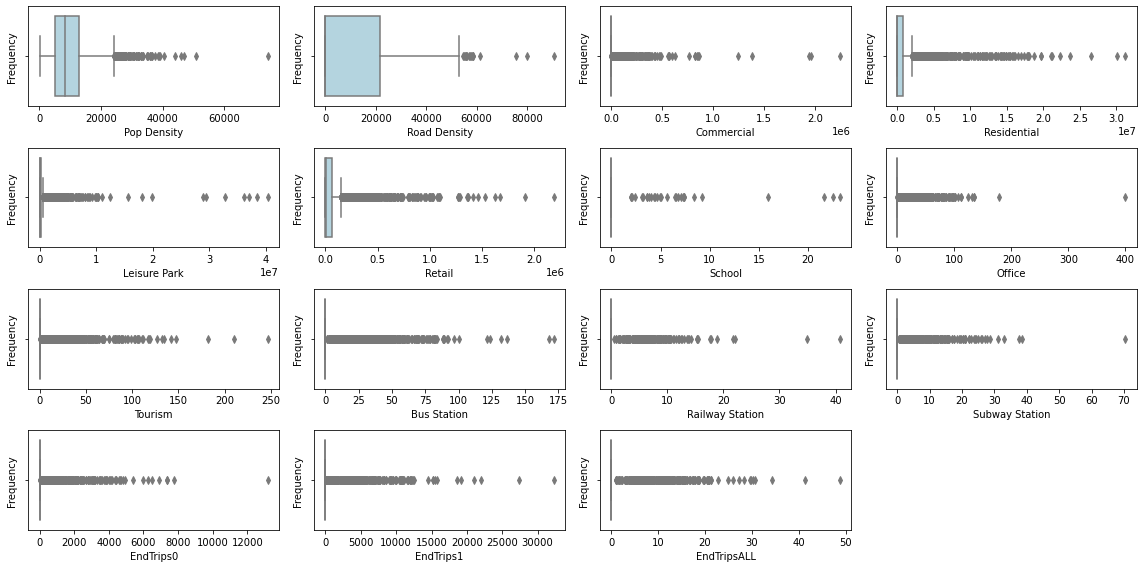

In [70]:
# create boxplot for each variable
columns = ['Pop Density', 'Road Density', 
           'Commercial', 'Residential', 'Leisure Park', 'Retail', 
           'School', 'Office','Tourism',
           'Bus Station', 'Railway Station', 'Subway Station',
           'EndTrips0', 'EndTrips1','EndTripsALL']

plt.figure(figsize=(16,8))

for i, column in enumerate(columns, start=1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=trips, x=column, color='lightblue')
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Due to unavalability of 2021 London census data of some LSOA areas, the correspoding row of bike trip ending station has null value as well. However, distance relevant variables are still complete for following analysing. So Stations with null value would be imputed rather than removed from this analysis.

In [20]:
'''
# 创建 SimpleImputer 对象
imputer = SimpleImputer(strategy='most_frequent') 

#拟合模型并进行插补
data_imputed = imputer.fit_transform(trips)

#将结果转回 DataFrame格式
trips = pd.DataFrame(data_imputed, columns=trips.columns, index=trips.index)
trips.describe()
'''

"\n# 创建 SimpleImputer 对象\nimputer = SimpleImputer(strategy='most_frequent') \n\n#拟合模型并进行插补\ndata_imputed = imputer.fit_transform(trips)\n\n#将结果转回 DataFrame格式\ntrips = pd.DataFrame(data_imputed, columns=trips.columns, index=trips.index)\ntrips.describe()\n"

In [48]:
trips.head(2)

,LSOA11CD,Pop Density,SHAPE_area,Commercial,Residential,Leisure Park,Retail,School,Office,Bus Station,Railway Station,Subway Station,Tourism,EndTripsALL,Road Density,EndTrips0,EndTrips1,geometry,endpointsALL_count
0,E01000001,10988.535489,133320.768859,1.245121e+06,0.0,30281.504785,0.000000,0.0,15.001414,52.504948,0.000000,7.500707,15.001414,0.000000,0.000000,0.000000,0.000000,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.000000
1,E01000002,6348.609213,226191.273063,8.232896e+05,0.0,15644.261706,57913.244372,0.0,39.789334,26.526222,4.421037,4.421037,61.894519,8.842074,392.713085,353.682964,1198.101042,"POLYGON ((532746.813 181786.891, 532671.688 18...",1551.784007


In [71]:

# 选择需要标准化的列
#columns_to_standardize = ['RetailRatio','CommerRatio', 'ResidentRatio', 'ParkRatio', 'METRO_DIST', 'CAZ_DIST', 'ResCoverS', 'BUS_DIST', 'RetailCoverS', 'ParkCoverS', 'CommerCoverS']
#columns_to_standardize = ['leisurepark_area_ratio',	retail_area_ratio	endpoints0_count_ratio	endpoints1_count_ratio	office_point_ratio	school_point_ratio	subway_point_ratio	tourism_point_ratio	endpointsALL_ratio	bus_point_ratio
columns_to_standardize = ['Pop Density','Road Density',
                          'Leisure Park', 'Retail', 'Commercial','Residential',
                          'EndTrips0', 'EndTrips1', 'EndTripsALL', 
                          'Office', 'School', 'Tourism',
                          'Subway Station', 'Bus Station','Railway Station']

 # 创建StandardScaler对象并进行标准化
scaler = MinMaxScaler()
trips[columns_to_standardize] = scaler.fit_transform(trips[columns_to_standardize])


# 输出前几行数据以确认修改已生效
trips.head()


,LSOA11CD,Pop Density,SHAPE_area,Commercial,Residential,Leisure Park,Retail,School,Office,Bus Station,Railway Station,Subway Station,Tourism,EndTripsALL,Road Density,EndTrips0,EndTrips1,geometry,endpointsALL_count
0,E01000001,0.146890,133320.768859,0.556422,0.000000,0.000750,0.000000,0.0,0.037506,0.306170,0.000000,0.106487,0.060812,0.000000,0.000000,0.000000,0.000000,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.000000
1,E01000002,0.084204,226191.273063,0.367913,0.000000,0.000388,0.026506,0.0,0.099480,0.154682,0.108574,0.062765,0.250904,0.181467,0.004336,0.026834,0.037115,"POLYGON ((532746.813 181786.891, 532671.688 18...",1551.784007
2,E01000003,0.315775,57302.966528,0.000000,0.013259,0.002178,0.016088,0.0,0.043631,0.000000,0.000000,0.000000,0.141484,0.000000,0.019764,0.000000,0.000000,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.000000
3,E01000005,0.068202,190738.760508,0.247167,0.002774,0.000308,0.012061,0.0,0.091755,0.458580,0.257509,0.223294,0.361297,0.107598,0.082092,0.025855,0.108329,"POLYGON ((533807.946 180767.770, 533649.063 18...",3837.709745
4,E01000006,0.157993,144195.846859,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.000000


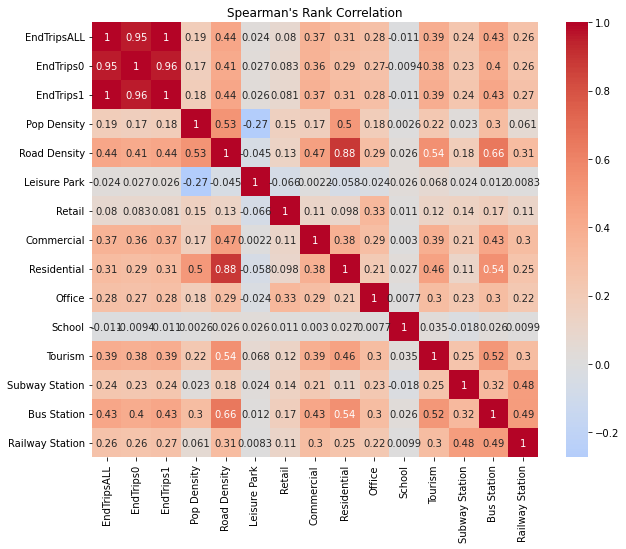

In [72]:
# Select the columns of interest
columns_of_interest = ['EndTripsALL','EndTrips0', 'EndTrips1',  
                        'Pop Density','Road Density',
                          'Leisure Park', 'Retail', 'Commercial','Residential',
                          'Office', 'School', 'Tourism',
                          'Subway Station', 'Bus Station','Railway Station']
# Calculate Spearman's rank correlation for the selected columns
correlation_matrix = trips[columns_of_interest].corr(method='spearman')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()

In [81]:
# Check multicollinearity
X = trips[['Pop Density','Road Density',
                          'Leisure Park', 'Retail', 'Commercial','Residential',
                          'Office', 'School', 'Tourism',
                          'Subway Station', 'Bus Station','Railway Station']]
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

           Features  VIF Factor
0       Pop Density    2.245307
1      Road Density    3.378078
2      Leisure Park    1.025315
3            Retail    1.217391
4        Commercial    1.109680
5       Residential    1.487776
6            Office    1.364095
7            School    1.006342
8           Tourism    1.581954
9    Subway Station    1.501111
10      Bus Station    2.340879
11  Railway Station    1.580647


**Result Explanation:**<br><br>
From the Spearman regression plot, we can observe that the coefficient between Road Density and residential area is very high (0.88). Additionally, "Road Density" shows a relatively high correlation with "Bus Station" (0.66), "Tourism" (0.54), "Pop Density" (0.53), and "Commercial" (0.47). Therefore, **Road Density** will be removed from the model to reduce multicollinearity.
<br><br>
Furthermore, Population Density was calculated as the ratio of "usual residents within LSOA unit" to "area of LSOA unit (km²)". This variable's role overlaps with "residential area", which is calculated as the ratio of "residential landuse area within LSOA unit" to "area of LSOA unit (km²)". Considering that the data source for population density is "English IMD 2019", which is not as recent as the "residential landuse" data (fetched using the Quick OSM plugin in QGIS in 2023), **"Pop Density"** will be removed from the model as well.

## Lasso Regression

In [74]:
trips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   LSOA11CD            4835 non-null   object  
 1   Pop Density         4835 non-null   float64 
 2   SHAPE_area          4835 non-null   float64 
 3   Commercial          4835 non-null   float64 
 4   Residential         4835 non-null   float64 
 5   Leisure Park        4835 non-null   float64 
 6   Retail              4835 non-null   float64 
 7   School              4835 non-null   float64 
 8   Office              4835 non-null   float64 
 9   Bus Station         4835 non-null   float64 
 10  Railway Station     4835 non-null   float64 
 11  Subway Station      4835 non-null   float64 
 12  Tourism             4835 non-null   float64 
 13  EndTripsALL         4835 non-null   float64 
 14  Road Density        4835 non-null   float64 
 15  EndTrips0           4835 non-n

### Lasso Regression Model for all destinations

In [88]:

# Lasso Regression
# Select columns with 16 independent variables & dependent logcount

# Split into predictor variables (X) and outcome variable (y)
X = trips[['Leisure Park', 'Retail', 'Commercial', 'Residential',
           'Office', 'School', 'Tourism',
           'Subway Station', 'Bus Station', 'Railway Station']]

y = trips['EndTripsALL']
#y = trips['EndTripsALL','EndTrips0', 'EndTrips1']


# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso.fit(X, y)

# Display the best alpha (lambda) value
best_alpha = lasso.alpha_
print("Best Alpha (Lambda):", best_alpha)

# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])  

Best Alpha (Lambda): 0.0001
          Variable  Coefficient
8      Bus Station     0.213181
4           Office     0.189754
6          Tourism     0.112265
3      Residential     0.031958
1           Retail    -0.003624
2       Commercial     0.003082
0     Leisure Park    -0.000000
5           School    -0.000000
7   Subway Station    -0.000000
9  Railway Station    -0.000000


In [89]:
# 计算模型性能指标
y_pred = lasso.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print("均方误差 (MSE):", mse)
print("均方根误差 (RMSE):", rmse)
print("决定系数 (R^2):", r2)

#  交叉验证
cv_scores = cross_val_score(lasso, X, y, cv=5)  # 5 折交叉验证
print("交叉验证得分:", cv_scores)
print("平均交叉验证得分:", np.mean(cv_scores))

均方误差 (MSE): 0.003365788835637552
均方根误差 (RMSE): 0.058015418947358746
决定系数 (R^2): 0.16579097360209472
交叉验证得分: [0.16640722 0.02937857 0.17593583 0.00234132 0.08836636]
平均交叉验证得分: 0.09248586207410411


### Lasso Regression Model for cluster 0

In [90]:

# Lasso Regression
# Select columns with 16 independent variables & dependent logcount

# Split into predictor variables (X) and outcome variable (y)
X = trips[['Leisure Park', 'Retail', 'Commercial', 'Residential',
           'Office', 'School', 'Tourism',
           'Subway Station', 'Bus Station', 'Railway Station']]

y = trips['EndTrips0']
#y = trips['EndTripsALL','EndTrips0', 'EndTrips1']


# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso.fit(X, y)

# Display the best alpha (lambda) value
best_alpha = lasso.alpha_
print("Best Alpha (Lambda):", best_alpha)

# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])  

Best Alpha (Lambda): 0.0001
          Variable  Coefficient
8      Bus Station     0.115913
4           Office     0.050563
6          Tourism     0.047284
0     Leisure Park     0.000000
1           Retail    -0.000000
2       Commercial     0.000000
3      Residential     0.000000
5           School    -0.000000
7   Subway Station     0.000000
9  Railway Station    -0.000000


In [91]:
# 计算模型性能指标
y_pred = lasso.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print("均方误差 (MSE):", mse)
print("均方根误差 (RMSE):", rmse)
print("决定系数 (R^2):", r2)

#  交叉验证
cv_scores = cross_val_score(lasso, X, y, cv=5)  # 5 折交叉验证
print("交叉验证得分:", cv_scores)
print("平均交叉验证得分:", np.mean(cv_scores))

均方误差 (MSE): 0.0014669447314423461
均方根误差 (RMSE): 0.03830071450302652
决定系数 (R^2): 0.1029904049036865
交叉验证得分: [ 0.08081767  0.01522526  0.11646938 -0.05615686  0.03773353]
平均交叉验证得分: 0.03881779737847786


In [ ]:
 #Export model_stats to an Excel file named "step_model.xlsx"
lasso_coef.to_excel("lasso_coef0.xlsx", index=True)

### Lasso Regression Model for cluster 1

In [92]:

# Lasso Regression
# Select columns with 16 independent variables & dependent logcount

# Split into predictor variables (X) and outcome variable (y)
X = trips[['Leisure Park', 'Retail', 'Commercial', 'Residential',
           'Office', 'School', 'Tourism',
           'Subway Station', 'Bus Station', 'Railway Station']]

y = trips['EndTrips1']
#y = trips['EndTripsALL','EndTrips0', 'EndTrips1']


# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso.fit(X, y)

# Display the best alpha (lambda) value
best_alpha = lasso.alpha_
print("Best Alpha (Lambda):", best_alpha)

# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])  

Best Alpha (Lambda): 0.0001
          Variable  Coefficient
8      Bus Station     0.166469
4           Office     0.126569
6          Tourism     0.072895
3      Residential     0.018071
0     Leisure Park    -0.000000
1           Retail    -0.000000
2       Commercial     0.000000
5           School    -0.000000
7   Subway Station     0.000000
9  Railway Station     0.000000


In [93]:
# 计算模型性能指标
y_pred = lasso.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print("均方误差 (MSE):", mse)
print("均方根误差 (RMSE):", rmse)
print("决定系数 (R^2):", r2)

#  交叉验证
cv_scores = cross_val_score(lasso, X, y, cv=5)  # 5 折交叉验证
print("交叉验证得分(cv_scores):", cv_scores)
print("平均交叉验证得分(means_cv_scores):", np.mean(cv_scores))

均方误差 (MSE): 0.0022207410414888285
均方根误差 (RMSE): 0.04712473916626837
决定系数 (R^2): 0.14587884215507252
交叉验证得分(cv_scores): [ 0.02320486  0.02414378  0.12525005 -0.31350847  0.08509336]
平均交叉验证得分(means_cv_scores): -0.011163284067237655


In [134]:
 #Export model_stats to an Excel file named "step_model.xlsx"
lasso_coef.to_excel("lasso_coef1.xlsx", index=True)

以上步骤用lasso regression初步筛选出相关系数为0的变量。Distance to Central Activity Zone(CAZ), Student Rate, Cycle to Commute population ratio, population density这些变量被剔除后，其他自变量被加入斯皮尔曼回归分析。<br><br>
The above steps were used in lasso regression to initially screen out variables with a correlation coefficient of zero." Distance to Central Activity Zone(CAZ)", "Cycle to Commute population ratio","Ratio of student residents" and "population density" were eliminated and the remaining independent variables were added to the Spearman regression analysis.

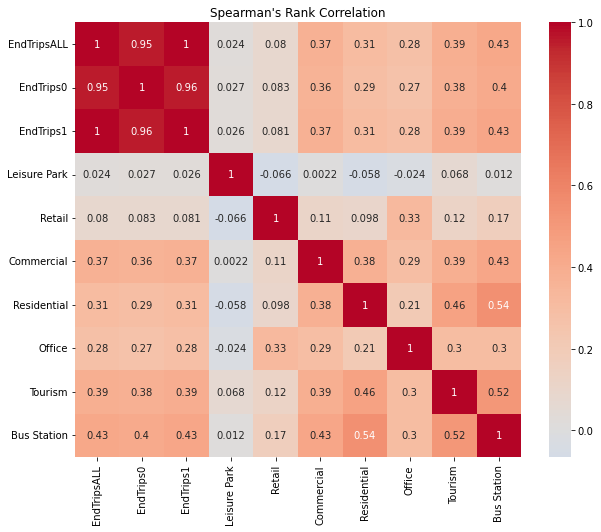

In [97]:
# Select the columns of interest
columns_of_interest = ['EndTripsALL','EndTrips0', 'EndTrips1',  
                          'Leisure Park', 'Retail', 'Commercial','Residential',
                          'Office',  'Tourism','Bus Station']

# variable removed :'Road Density','POP density': high correlation with other independent variables
# variable removed : 'School','Subway Station','Railway Station': close to zero coefficient in lasso regression model

# Calculate Spearman's rank correlation for the selected columns
correlation_matrix = trips[columns_of_interest].corr(method='spearman')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()

In [100]:
# Check multicollinearity
X = trips[['Leisure Park', 'Retail', 'Commercial','Residential',
                          'Office',  'Tourism','Bus Station']]
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

       Features  VIF Factor
0  Leisure Park    1.007343
1        Retail    1.111100
2    Commercial    1.097546
3   Residential    1.063915
4        Office    1.309760
5       Tourism    1.477303
6   Bus Station    1.476287


In [105]:
trips.head(2)

,LSOA11CD,Pop Density,SHAPE_area,Commercial,Residential,Leisure Park,Retail,School,Office,Bus Station,Railway Station,Subway Station,Tourism,EndTripsALL,Road Density,EndTrips0,EndTrips1,geometry,endpointsALL_count
0,E01000001,0.146890,133320.768859,0.556422,0.0,0.000750,0.000000,0.0,0.037506,0.306170,0.000000,0.106487,0.060812,0.000000,0.000000,0.000000,0.000000,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.000000
1,E01000002,0.084204,226191.273063,0.367913,0.0,0.000388,0.026506,0.0,0.099480,0.154682,0.108574,0.062765,0.250904,0.181467,0.004336,0.026834,0.037115,"POLYGON ((532746.813 181786.891, 532671.688 18...",1551.784007


### CLuster 0 OLS model

In [106]:
# Final OLS
# Define the independent variables and the dependent variable
X = trips[['Leisure Park', 'Retail', 'Commercial', 'Residential', 'Office', 'Tourism', 'Bus Station']]
y0 = trips['EndTrips0']
y1 = trips['EndTrips1']
y2 = trips['EndTripsALL']

# Add an intercept term
X = sm.add_constant(X)

In [103]:

# Create and fit the linear regression model for EndTrips0
lm_endtrips0 = sm.OLS(y0, X).fit()

# Get AIC and BIC for EndTrips0 model
aic_value_endtrips0 = lm_endtrips0.aic
bic_value_endtrips0 = lm_endtrips0.bic

# Print AIC and BIC for EndTrips0 model
print("EndTrips0 Model:")
print(f'AIC 0: {aic_value_endtrips0}')
print(f'BIC 0: {bic_value_endtrips0}')
print(lm_endtrips0.summary())


EndTrips0 Model:
AIC: -17848.990003382376
BIC: -17797.120912119277
                            OLS Regression Results                            
Dep. Variable:              EndTrips0   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     85.53
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          9.80e-118
Time:                        08:55:40   Log-Likelihood:                 8932.5
No. Observations:                4835   AIC:                        -1.785e+04
Df Residuals:                    4827   BIC:                        -1.780e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

### CLuster 1 OLS model

In [107]:

# Create and fit the linear regression model for EndTrips1
lm_endtrips1 = sm.OLS(y1, X).fit()

# Get AIC and BIC for EndTrips1 model
aic_value_endtrips1 = lm_endtrips1.aic
bic_value_endtrips1 = lm_endtrips1.bic

# Print AIC and BIC for EndTrips1 model
print("EndTrips1 Model:")
print(f'AIC: {aic_value_endtrips1}')
print(f'BIC: {bic_value_endtrips1}')
print(lm_endtrips1.summary())


EndTrips1 Model:
AIC: -15837.24637715613
BIC: -15785.377285893032
                            OLS Regression Results                            
Dep. Variable:              EndTrips1   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     123.3
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          2.96e-167
Time:                        09:00:02   Log-Likelihood:                 7926.6
No. Observations:                4835   AIC:                        -1.584e+04
Df Residuals:                    4827   BIC:                        -1.579e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

### CLuster 2 OLS model

In [108]:
# Create and fit the linear regression model for EndTripsALL
lm_endtripsall = sm.OLS(y2, X).fit()

# Get AIC and BIC for EndTripsALL model
aic_value_endtripsall = lm_endtripsall.aic
bic_value_endtripsall = lm_endtripsall.bic

# Print AIC and BIC for EndTripsALL model
print("EndTripsALL Model:")
print(f'AIC all: {aic_value_endtripsall}')
print(f'BIC all: {bic_value_endtripsall}')
print(lm_endtripsall.summary())


EndTripsALL Model:
AIC all: -13824.274346531616
BIC all: -13772.405255268517
                            OLS Regression Results                            
Dep. Variable:            EndTripsALL   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     142.3
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          2.58e-191
Time:                        09:00:40   Log-Likelihood:                 6920.1
No. Observations:                4835   AIC:                        -1.382e+04
Df Residuals:                    4827   BIC:                        -1.377e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [71]:
# Final Lasso
# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])

# Predict logcount on the entire dataset
y_pred = lasso_final.predict(X)

# Evaluate the model on training data
mse_train = mean_squared_error(y, y_pred)
r2_train = r2_score(y, y_pred)
cv_r2 = cross_val_score(lasso_final, X, y, cv=5, scoring='r2').mean()

# Print additional evaluation metrics
print(f'Mean Squared Error (MSE) on training data: {mse_train}')
print(f'R-squared on training data: {r2_train}')
print(f'Cross-validated R-squared: {cv_r2}')

       Variable  Coefficient
1      BUS_DIST    -0.228323
6  CommerCoverS     0.173802
5    ParkCoverS     0.161655
7    Deprivatio    -0.135729
4     ResCoverS    -0.072944
8       RoadDen    -0.062987
3  RetailCoverS     0.028344
0         const     0.000000
2      CAZ_DIST    -0.000000
Mean Squared Error (MSE) on training data: 0.07002147999875201
R-squared on training data: 0.06717004481639943
Cross-validated R-squared: -0.040099634985531284


In [112]:


# Split data into training and testing sets
X_train, X_test, y0_train, y0_test = train_test_split(X, y0, test_size=0.2, random_state=42)
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso0 = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso0.fit(X_train, y0_train)

lasso1 = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso1.fit(X_train, y1_train)

lasso2 = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso2.fit(X_train, y2_train)

# Get the best alpha value
best_alpha0 = lasso0.alpha_
best_alpha1 = lasso1.alpha_
best_alpha2 = lasso2.alpha_

# Get the coefficients
coefficients0 = lasso0.coef_
coefficients1 = lasso1.coef_
coefficients2 = lasso2.coef_

# Print the best alpha values
print("Best alpha for EndTrips0:", best_alpha0)
print("Best alpha for EndTrips1:", best_alpha1)
print("Best alpha for EndTripsALL:", best_alpha2)

# Print the coefficients
print("Coefficients for EndTrips0:", coefficients0)
print("Coefficients for EndTrips1:", coefficients1)
print("Coefficients for EndTripsALL:", coefficients2)

# Predictions
y0_pred = lasso0.predict(X_test)
y1_pred = lasso1.predict(X_test)
y2_pred = lasso2.predict(X_test)

# Model evaluation
mse0 = mean_squared_error(y0_test, y0_pred)
mse1 = mean_squared_error(y1_test, y1_pred)
mse2 = mean_squared_error(y2_test, y2_pred)

r2_0 = r2_score(y0_test, y0_pred)
r2_1 = r2_score(y1_test, y1_pred)
r2_2 = r2_score(y2_test, y2_pred)

print("MSE for EndTrips0:", mse0)
print("MSE for EndTrips1:", mse1)
print("MSE for EndTripsALL:", mse2)

print("R^2 for EndTrips0:", r2_0)
print("R^2 for EndTrips1:", r2_1)
print("R^2 for EndTripsALL:", r2_2)


Best alpha for EndTrips0: 0.0001
Best alpha for EndTrips1: 0.0001
Best alpha for EndTripsALL: 0.0001
Coefficients for EndTrips0: [ 0.         -0.         -0.          0.          0.00220454  0.06814998
  0.05183777  0.11342051]
Coefficients for EndTrips1: [ 0.         -0.         -0.          0.          0.02734054  0.13742688
  0.07437757  0.15949736]
Coefficients for EndTripsALL: [ 0.         -0.         -0.00733724  0.          0.04215017  0.21170441
  0.11098756  0.20907661]
MSE for EndTrips0: 0.0011966648788487193
MSE for EndTrips1: 0.0015394213116326654
MSE for EndTripsALL: 0.002297023404704126
R^2 for EndTrips0: 0.0796259486477513
R^2 for EndTrips1: 0.16617262149117695
R^2 for EndTripsALL: 0.1671816227813262


The lasso regression results show that the distance to the nearest bus station (m), nearest metro station (m), the population density and university percentage variables are not significant at the 95% level of confidence. However, ratio of household with no car is significant, while the distance to the nearest metro station ranked second in the p-value performance.

Examining the variables in more detail shows that there is some positive correlation between bike parking counts at docking points and area of leisure park within 500m buffer area, as well as commercial and retail landuse. Besideds, there is some negative correlation between bike parking counts at docking points and road density around the station, also distance to central activity zone centre and deprivation rate of the corresonding LSOA area. However, the strength of the association appears relatively low.

## TRY1:SVM

Mean Squared Error (MSE): 0.010150745569581334
R-squared: -2.68029661147805


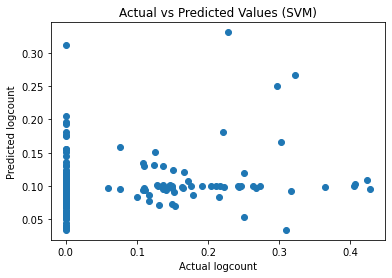

In [121]:

# Define the independent variables and the dependent variable
X = trips[['Leisure Park', 'Retail', 'Commercial', 'Residential', 'Office', 'Tourism', 'Bus Station']]
y = trips['EndTripsALL']
#y1 = trips['EndTrips1']
#y2 = trips['EndTripsALL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the Support Vector Regression (SVR) model
svm_model = SVR(kernel='rbf')  # You can choose other kernels like 'linear','rbf' or 'poly' based on your data
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print evaluation metrics with explanations
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')

# Plot actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual logcount')
plt.ylabel('Predicted logcount')
plt.title('Actual vs Predicted Values (SVM)')
plt.show()


In [ ]:
# Get feature weights from the SVM model
feature_weights = svm_model.coef_

# Plot feature weights
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_weights)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights from SVM Model')
plt.show()


## Stepwise Regression

For comparison, the second model-stepwise regression was built. Both forward and backward selection were checked by using AIC criterion, and backward selection was found a better model accuracy and fit. 

In [49]:

trips2 = pd.read_csv("ALL_OSM_Rat4.csv")
trips2['logcount'] = np.log10(trips2['counts'])
trips2 = trips2.dropna()

# Stepwise Regression
# Full model
X = trips2.drop(columns=['logcount','FID','EndStationID','count_ratio','counts','AllusualRe','Deprivatio.1','MetroCommu.1','BusCommute.1','OfficeWork','CycleCommu','StudentRat', 'POPDEN'])
X = sm.add_constant(X)
y = trips2['logcount']
full_model = sm.OLS(y, X).fit()


# Backward stepwise selection using AIC criterion
step_model = full_model
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    max_vif = vif[vif['Variable'] != 'const']['VIF'].max()
    
    if max_vif > 10:  # You can adjust the VIF threshold as needed
        remove_variable = vif[vif['VIF'] == max_vif]['Variable'].values[0]
        X = X.drop(columns=[remove_variable])
        step_model = sm.OLS(y, X).fit()
    else:
        break

# Display the stepwise regression summary
print(step_model.summary())

# Check for multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif)


                            OLS Regression Results                            
Dep. Variable:               logcount   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     7.981
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           9.77e-17
Time:                        15:23:19   Log-Likelihood:                -29.352
No. Observations:                 680   AIC:                             90.70
Df Residuals:                     664   BIC:                             163.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.3326      0.153     28.292

### Stepwise regression removing outliers 

Lastly, to further verify the significance of the variables, we ran a stepwise regression model with the three ‘outlier stations’ removed – the three stations with the highest number of trips. 


In [86]:

trips1 = pd.read_csv("ALL_OSM_Rat4.csv")
trips1['logcount'] = np.log10(trips1['counts'])
trips1 = trips1.dropna()


# remove outliers
mean_value = trips1['logcount'].mean()
std_value = trips1['logcount'].std()
threshold = 3 * std_value
trips1 = trips1[abs(trips1['logcount'] - mean_value) <= threshold]

# Final Stepwise Regression
# Full model
#X = trips1.drop(columns=['logcount','FID','EndStationID','count_ratio','counts','AllusualRe','Deprivatio.1','MetroCommu.1','BusCommute','BusCommute.1','OfficeWork','CycleCommu','StudentRat','RAIL_DIST','METRO_DIST','JobDensity','Deprivatio','NoCar','CAZ_DIST','RetailRatio','CommerCoverS','RetailCoverS','ParkCoverS','RoadDen'])
selected=['BUS_DIST','ResCoverS','CarorVanCo', 'ResidentRatio', 'CommerRatio','ParkCoverS','RoadDen','POPDEN']
X = trips1[selected]
X = sm.add_constant(X)
y = trips1['logcount']
full_model = sm.OLS(y, X).fit()

# Backward stepwise selection using AIC criterion
step_model = full_model
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    max_vif = vif[vif['Variable'] != 'const']['VIF'].max()
    
    if max_vif > 5:  # You can adjust the VIF threshold as needed
        remove_variable = vif[vif['VIF'] == max_vif]['Variable'].values[0]
        X = X.drop(columns=[remove_variable])
        step_model = sm.OLS(y, X).fit()
    else:
        break

# Display the stepwise regression summary
print(step_model.summary())


# Check for multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif)



# Fit stepwise regression model 
# Calculate VIF values
X = step_model.model.exog  # Extract the design matrix (including constant)
vif = pd.DataFrame()
vif["Variable"] = step_model.model.exog_names[1:]  # Exclude the constant term
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(1, X.shape[1])]

# Create a DataFrame for model statistics
model_stats = pd.DataFrame({'Estimate': step_model.params,
                            'Standard Error': step_model.bse,
                            't-value': step_model.tvalues,
                            'p-value': step_model.pvalues})



# Display the table in the Jupyter Notebook
model_stats

                            OLS Regression Results                            
Dep. Variable:               logcount   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     20.51
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           4.98e-25
Time:                        17:27:12   Log-Likelihood:                 30.195
No. Observations:                 675   AIC:                            -44.39
Df Residuals:                     667   BIC:                            -8.273
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.2528      0.033    127.737

,Estimate,Standard Error,t-value,p-value
const,4.252789e+00,3.329321e-02,127.737402,0.000000e+00
BUS_DIST,-2.112818e-04,5.968433e-05,-3.539987,4.279673e-04
CarorVanCo,-1.456830e+00,1.935303e-01,-7.527660,1.680915e-13
ResidentRatio,-3.870490e+00,1.453622e+00,-2.662653,7.939688e-03
CommerRatio,1.013832e+00,4.770472e-01,2.125223,3.393495e-02
ParkCoverS,1.962751e-07,1.059698e-07,1.852179,6.444174e-02
RoadDen,-1.310748e-01,5.563722e-02,-2.355884,1.876712e-02
POPDEN,-2.888553e+00,1.292823e+00,-2.234299,2.579395e-02


In [106]:
# Export model_stats to an Excel file named "step_model.xlsx"
#model_stats.to_excel("step_model1.xlsx", index=False)

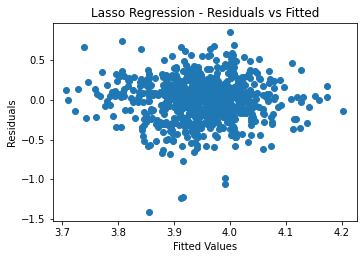

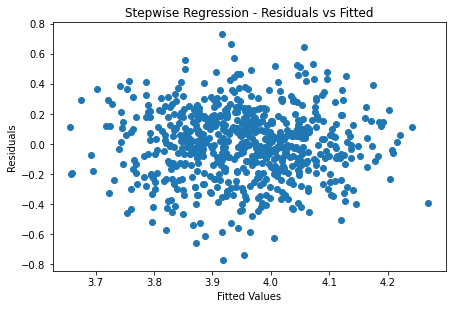

In [89]:
# Lasso regression
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.title("Lasso Regression - Residuals vs Fitted")
plt.scatter(lm_all.fittedvalues, lm_all.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")


# Stepwise regression
plt.figure(figsize=(12, 8))
plt.subplot(2,2,2)
plt.title("Stepwise Regression - Residuals vs Fitted")
plt.scatter(step_model.fittedvalues, step_model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

'''
plt.subplot(2, 2, 3)
plt.title("Lasso Regression - Normal Q-Q Plot")
sm.qqplot(lm_all.resid, line='r')

plt.subplot(2, 2, 4)
plt.title("Stepwise Regression - Normal Q-Q Plot")
sm.qqplot(step_model.resid, line='r')
'''
plt.tight_layout()
plt.show()


We can see from the Residual vs Fitted plot that residuals are randomly scattered and centered around zero, it suggests that the variance of the residuals is roughly constant across all levels of the predicted values. The Stepwise Regression model is doing a more reasonable job of capturing the variation in the data than Lasso Regression.

Overall, we can conclude from this regression analysis that in London Santander Service Area. Increased distances to bus station and residential area within buffer area are associated with lower bike-sharing demand. Additionally, bike-sharing ridership is significantly higher among populations that have fewer employment deprived residents, and in areas with a higher proportion of cycling lanes. 

In [ ]:


# Perform stepwise regression removing outliers
outlier_indices = [10, 12, 13]
trips_removed_outliers = trips.drop(outlier_indices)
step_model_removed_outliers = ols('logcount ~ ST_DIST + DOWNTOWN_DIST + CYL_PER1 + employment + uni + population_density', data=trips_removed_outliers).fit().step(direction='both', verbose=0)
print(step_model_removed_outliers.summary())

Compare AIC values：比较Lasso回归模型和逐步回归模型的AIC值，AIC值越小越好，表示模型对数据的拟合越好。 comparing the AIC values of the Lasso regression model and the stepwise regression model, the smaller the AIC value, the better it indicates that the model fits the data better.

In [ ]:
'''
if lasso_aic < step_aic:
    print("Lasso Regression is preferred with AIC =", lasso_aic)
else:
    print("Stepwise Regression is preferred with AIC =", step_aic)
'''

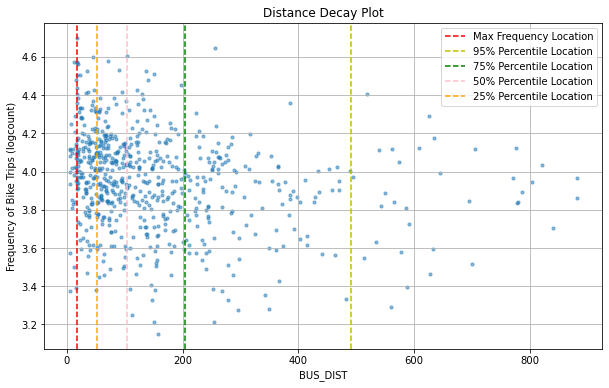

In [34]:


# Assuming you have a DataFrame 'trips1' with 'BUS_DIST' and 'logcount' columns
x = trips1['BUS_DIST']
y = trips1['logcount']

# Calculate the maximum frequency location
max_freq_location = x[y.idxmax()]

# Calculate the 75th percentile location
percentile_95_location = np.percentile(x, 95)
percentile_75_location = np.percentile(x, 75)
percentile_50_location = np.percentile(x, 50)
percentile_25_location = np.percentile(x, 25)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10)
plt.axvline(x=max_freq_location, color='r', linestyle='--', label='Max Frequency Location')
plt.axvline(x=percentile_95_location, color='y', linestyle='--', label='95% Percentile Location')
plt.axvline(x=percentile_75_location, color='g', linestyle='--', label='75% Percentile Location')
plt.axvline(x=percentile_50_location, color='pink', linestyle='--', label='50% Percentile Location')
plt.axvline(x=percentile_25_location, color='orange', linestyle='--', label='25% Percentile Location')

plt.xlabel('BUS_DIST')
plt.ylabel('Frequency of Bike Trips (logcount)')
plt.title('Distance Decay Plot')
plt.grid(True)
plt.legend()
plt.show()


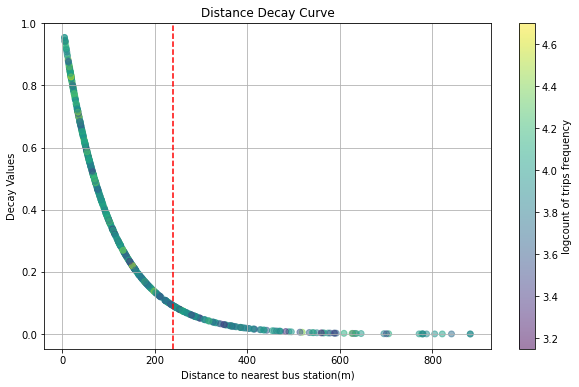

In [136]:

# 定义距离衰减函数
def distance_decay(distance, decay_rate):
    return np.exp(-decay_rate * distance)

# 从trips1数据集中获取BUS_DIST和logcount列
bus_dist = trips1['BUS_DIST']
logcount = trips1['logcount']

# 计算距离衰减曲线
decay_rate = 0.01  # 适当调整衰减率
decay_values = distance_decay(bus_dist, decay_rate)


# 绘制距离衰减曲线
plt.figure(figsize=(10, 6))
plt.scatter(bus_dist, decay_values, c=logcount, cmap='viridis', alpha=0.5)
plt.axvline(x=bus_dist[turning_points[0]], color='red', linestyle='--', label='Turning Point')
plt.xlabel('Distance to nearest bus station(m)')
plt.ylabel('Decay Values')
plt.title('Distance Decay Curve')
plt.colorbar(label='logcount of trips frequency')
plt.grid(True)

# 导出距离衰减曲线图，设置 dpi 参数以提高分辨率
plt.savefig('distance_decay_curve_BusStation.jpg', dpi=200)

# 显示图形
plt.show()


## TRY2 :Ramdom Forest Regressor

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [6]:
trips.describe()

,USUALRES,SHAPE_area,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,tourism_point,endpointsALL,road_length,endpoints0_count,endpoints1_count,endpointsALL_count
count,4835.000000,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,9599.015743,3.254407e+05,1.083900e+04,8.237064e+05,3.963512e+05,6.537795e+04,0.043171,4.181821,4.432926,0.310733,0.510088,3.978876,0.709006,9037.411609,93.079303,322.273898,415.353202
std,6145.772217,6.290090e+05,7.724015e+04,2.222223e+06,1.681537e+06,1.529593e+05,0.718236,13.473848,13.314363,1.765168,2.800354,13.835861,3.095333,14906.584646,533.061025,1646.176627,2090.181811
min,115.948617,1.690171e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5203.187837,1.335480e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8338.729292,2.033552e+05,0.000000e+00,0.000000e+00,1.976717e+04,5.554149e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12813.689484,3.190558e+05,0.000000e+00,8.162215e+05,2.234297e+05,5.869405e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21574.245843,0.000000,0.000000,0.000000
max,74134.494912,1.580873e+07,2.237729e+06,3.122514e+07,4.036401e+07,2.184887e+06,23.212422,399.973171,171.489286,40.719193,70.437560,246.686506,48.725512,90560.111599,13180.251048,32280.651827,45460.902875


In [5]:
# create feature matrix X and target variable y
#selected=['BUS_DIST','ResCoverS','CarorVanCo', 'ResidentRatio', 'CommerRatio','ParkCoverS','RoadDen','POPDEN']
# selected=['BUS_DIST', 'CAZ_DIST', 'RetailCoverS', 'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'RoadDen']
selected = ['EndTripsALL','EndTrips0', 'EndTrips1',  
                        'Pop Density','Road Density',
                          'Leisure Park', 'Retail', 'Commercial','Residential',
                          'Office', 'School', 'Tourism',
                          'Subway Station', 'Bus Station','Railway Station']
X = trips[selected]
y = trips['EndTripsAll']

#X = sm.add_constant(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 创建决策树回归模型
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X_train, y_train)

# 进行预测
y_pred = regressor.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics with explanations
print(f'Mean Squared Error (MSE): {mse}')

KeyError: "None of [Index(['EndTripsALL', 'EndTrips0', 'EndTrips1', 'Pop Density', 'Road Density',\n       'Leisure Park', 'Retail', 'Commercial', 'Residential', 'Office',\n       'School', 'Tourism', 'Subway Station', 'Bus Station',\n       'Railway Station'],\n      dtype='object')] are in the [columns]"

In [68]:
# 假设 X 是自变量，y 是连续型目标变量 logcount
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X, y)

# 获取特征重要性分数
feature_importance = regressor.feature_importances_

# 将特征重要性分数与对应的特征名字关联起来
feature_names = X.columns  # 假设你的自变量在一个DataFrame中
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 将特征重要性评分表按分数从大到小排序
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 打印排序后的特征重要性评分表
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: CommerCoverS, Importance: 0.23652144323100752
Feature: BUS_DIST, Importance: 0.1676259609741178
Feature: CAZ_DIST, Importance: 0.13163232652835732
Feature: RoadDen, Importance: 0.10585821331898403
Feature: ParkCoverS, Importance: 0.10523610281102164
Feature: ResCoverS, Importance: 0.09968480886237562
Feature: Deprivatio, Importance: 0.08678810952866954
Feature: RetailCoverS, Importance: 0.06665303474546641


AttributeError: 'BarContainer' object has no attribute 'get_array'

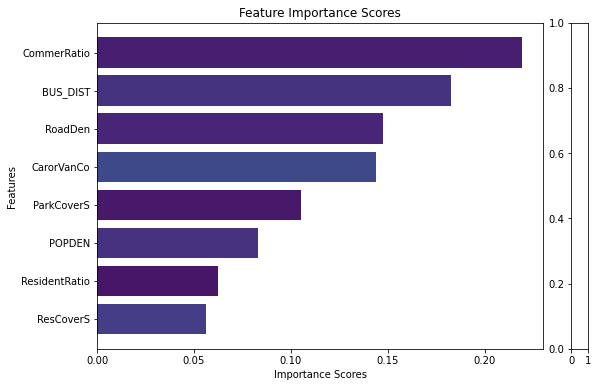

In [62]:
# 假设 X 是自变量，y 是连续型目标变量 logcount
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X, y)

# 获取特征重要性分数
feature_importance = regressor.feature_importances_

# Associate feature importance scores with corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# Plot the horizontal bar chart with different colors
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(feature_importance)  # Use a colormap for colors

# Extract feature names and importance scores for plotting
features, importance_scores = zip(*sorted_feature_importance)

# Create a horizontal bar chart
bars = plt.barh(features, importance_scores, color=colors)

# Customize the plot
plt.title('Feature Importance Scores')
plt.xlabel('Importance Scores')
plt.ylabel('Features')

# Add a colorbar to indicate the importance values
cbar = plt.colorbar(bars)
cbar.set_label('Importance Values')

# Show the plot
plt.tight_layout()
plt.show()